# Tutorial 7: Re-Construyendo Nuestra Red Neuronal
## Objetivo
En este tutorial, exploraremos no solo problemas, sino también cómo podemos mejorar la red que teníamos previamente. Por ende, vamos a entender mecanismos de generalización como la normalización, dropout, data augmentation, entre otros.

### Dataset
Continuaremos con el mismo dataset, pero lo aumentaremos mediante la técnica de data augmentation. Específicamente, utilizaremos algo conocido como "SMOTE: Synthetic Minority Over-sampling Technique", que es una técnica que nos permite aumentar la cantidad de datos de una clase en particular. Realizaremos este aumento para las 3 clases que tenemos, para que con más ejemplos nuestro modelo pueda generalizar mejor.

Los métodos de data augmentation más comunes dependerán del tipo de dato con el que estemos trabajando. Por ejemplo, en imágenes, podemos hacer rotaciones, traslaciones, etc. En el caso de texto, podemos aumentar el texto mediante sinónimos, eliminando palabras, etc. En el caso de series de tiempo, podemos aumentar la serie mediante la adición de ruido, etc.

## Otros métodos de regularización
- **Ensamblaje:** Consiste en tener varios modelos entrenados en el mismo dataset, y hacer un promedio de las predicciones de cada modelo. Es como consultar a varios doctores para un diagnóstico y luego, dada la información común de cada uno, tomar una mejor decisión sobre el diagnóstico.

- **Entrenamiento Adversarial (Adversarial Training):** Se trata de agregar ruido a los datos de entrada para así forzar que el modelo pueda lidiar con ejemplos más variados y reales.

- **Early Stopping (Detención Temprana):** Detener el entrenamiento cuando el error de validación comienza a aumentar, lo que nos permite evitar el sobreajuste.


In [1]:
from sklearn.datasets import load_iris
import torch

data = load_iris()

train_data = data['data']
train_traget = data['target']

# Infelizmente el analisis de como són los datos no es tan rapido, por ende ire explicar las decisiones que tome.


print(train_traget[0])

X = torch.tensor(train_data, dtype=torch.float32)
y = torch.tensor(train_traget, dtype=torch.long)


0


In [12]:
import pandas as pd
import random

df = pd.DataFrame(train_data)
df['class'] = train_traget
# mean maxium and minum for each column by class
result = df.groupby('class').agg([min, max, 'mean', 'std'])

new_sample = []
for i in range(4):
    new_sample.append(result[i]['mean'][1] + random.uniform(-result[i]['std'][1]**2, result[i]['std'][1]**2))
                    
print(new_sample)
result

[6.006037721461456, 2.747160679381733, 4.315842485668202, 1.2921272059817712]


0                          1                          2              \
       min  max   mean       std  min  max   mean       std  min  max   mean   
class                                                                          
0      4.3  5.8  5.006  0.352490  2.3  4.4  3.428  0.379064  1.0  1.9  1.462   
1      4.9  7.0  5.936  0.516171  2.0  3.4  2.770  0.313798  3.0  5.1  4.260   
2      4.9  7.9  6.588  0.635880  2.2  3.8  2.974  0.322497  4.5  6.9  5.552   

                   3                        
            std  min  max   mean       std  
class                                       
0      0.173664  0.1  0.6  0.246  0.105386  
1      0.469911  1.0  1.8  1.326  0.197753  
2      0.551895  1.4  2.5  2.026  0.274650

# Ahora iremos poblar el dataset con nuestros ejemplos sinteticos

In [22]:
# create 1000 new samples for each class
new_samples = []
for i in range(3):
    for j in range(1000):
        new_sample = []
        for k in range(4):
            new_sample.append(result[k]['mean'][i] + random.uniform(-result[k]['std'][i]**2, result[k]['std'][i]**2))
        new_sample.append(i)
        new_samples.append(new_sample)

# add new samples to the original df
new_df = pd.DataFrame(new_samples, columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'class'])
new_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.129926,3.570076,1.448661,0.256499,0
1,5.093759,3.486221,1.468076,0.248273,0
2,4.889191,3.436088,1.434608,0.248924,0
3,5.117173,3.468344,1.446430,0.251098,0
4,4.939075,3.536922,1.473060,0.246126,0
...,...,...,...,...,...
2995,6.324302,2.945824,5.538625,2.034549,2
2996,6.790998,2.941746,5.725237,2.062427,2
2997,6.434255,2.939869,5.807151,1.985672,2
2998,6.211359,2.873937,5.692014,1.984954,2


In [23]:
#from new df create new X and y
new_X = torch.tensor(new_df.drop('class', axis=1).values, dtype=torch.float32)
new_y = torch.tensor(new_df['class'].values, dtype=torch.long)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [27]:
from torch.optim import SGD

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

epoch_loss = []

for epoch in range(1000):
    optimizer.zero_grad()
    output = model(new_X)
    loss = criterion(output, new_y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    epoch_loss.append(loss.item())
print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.168784499168396
Epoch 101, Loss: 0.5010326504707336
Epoch 201, Loss: 0.3390735387802124
Epoch 301, Loss: 0.234945148229599
Epoch 401, Loss: 0.1602201610803604
Epoch 501, Loss: 0.1119043380022049
Epoch 601, Loss: 0.08178284019231796
Epoch 701, Loss: 0.06244400143623352
Epoch 801, Loss: 0.04948386549949646
Epoch 901, Loss: 0.040415119379758835
Epoch 1000, Loss: 0.033882319927215576


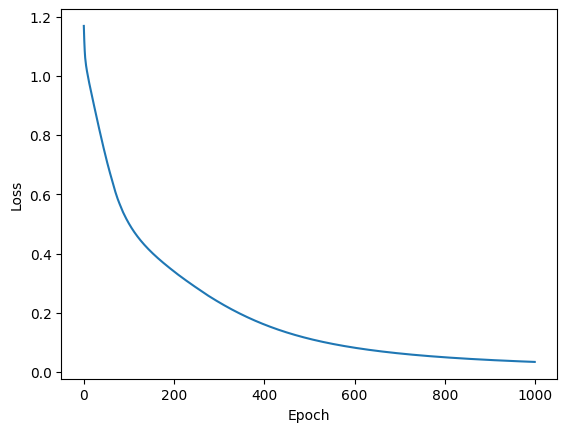

Accuracy: 98.0%


In [28]:

import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_losses = []

import torch.nn.functional as F

with torch.no_grad():
    # Forward pass
    outputs = model(X)
    
    # Apply Softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)
    
    # Get the predicted class
    _, predicted_class = torch.max(probabilities, 1)

correct = (predicted_class == y).sum().item()
total = y.size(0)
accuracy = correct / total
print(f'Accuracy: {accuracy * 100}%')



# Otras tenicas que podemos hacer

## Normalización
 - Normalización de los datos de entrada
 - Normalización de los datos de salida
 - Batch Normalizatión 

### Reeordenar datos de entrada, para que no se aprenda el orden de los datos

# Regularización
 - L1-L2
 - WeightDecay
 - dropout
- early stopping
 - esamble

# Esto es lo que veremos el proximo tutorial